In [1]:
import pandas as pd 
import numpy as np
import tweepy
import datetime
import requests
import re
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
from timeit import default_timer as timer

# (1) Gathering data

In [2]:
#read the given file of 'twitter-archive-enhanced.csv'
archive= pd.read_csv('twitter-archive-enhanced.csv')
archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [3]:
#get the file of 'image prediction from a URL'
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response= requests.get(url)

if not os.path.isfile("img_predictions.tsv"):
    with open("img_predictions.tsv", 'wb') as file:
        file.write(response.content)

img_predictions= pd.read_csv("img_predictions.tsv", sep='\t')
img_predictions.head(1)

## if I used 'w' insted of 'wb' in the open function... I'll need the following code
# from io import StringIO
# s=str(response.content,'utf-8')
# img_predictions= StringIO(s) 
# img_predictions= pd.read_csv(img_predictions, sep='\t')
# img_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [4]:
#get the needed data (retweet count - favorite count) from twitter API
consumer_key = '*********'
consumer_secret = '*********'
access_token = '*********'
access_secret = '*********'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

##checking the API
tweet= api.get_status(892420643555336193)
print(tweet.text,'\n', tweet.user.screen_name,'\n', tweet.favorite_count,'\n', tweet.retweet_count)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU 
 dog_rates 
 34887 
 7320


In [5]:
errors= {}
start = timer()

#if statement: to avoid making the file again (incase we re-run the whole code)
if not os.path.isfile('tweet_json.txt'):
    with open ('tweet_json.txt', 'w') as file:
        
        for tweet_id in archive['tweet_id']:
            try:
                tweet= api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode='extended')
                json.dump(tweet._json, file)
                file.write('\n')
            except Exception as e:
                print('error at tweet of id=', tweet_id, ', which is', str(e))
                errors[tweet_id]= e

end = timer()
elapsed_time= end - start
print('elapsed time=', elapsed_time)
#real elapsed time to gather the data from API=  1288 sec  =  21.5 min

elapsed time= 0.0016329400000358874


In [6]:
tweets_list= []

##open tweet_json.txt and read it into a dataframe
with open('tweet_json.txt', 'r') as file:
    for  line in file:
        #I use .loads not .load because the line contains strings
        tweet= json.loads(line)
        tweet_id= tweet['id']
        retweet_count= tweet['retweet_count']
        favorite_count= tweet['favorite_count']
        tweets_list.append({ 'tweet_id': tweet_id,
                    'retweet_count': retweet_count,
                    'favorite_count': favorite_count})
#         tweets_list.append(tweet)
        
api_df= pd.DataFrame(tweets_list)        

api_df.head(3)

,favorite_count,retweet_count,tweet_id
0,34912,7326,892420643555336193
1,30234,5469,892177421306343426
2,22752,3616,891815181378084864


# (1) Aseesing data

### assesing archive

In [63]:
archive.sample(3)
# archive[archive['tweet_id']==771014301343748096]['expanded_urls'].tolist()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
1116,732585889486888962,NaN,NaN,2016-05-17 14:57:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...","When your teacher agreed on 10,000 RTs and no ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/732585889...,10,10,None,None,None,None,None
1548,689275259254616065,NaN,NaN,2016-01-19 02:36:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Lucky. He was showing his friends an extr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689275259...,10,10,Lucky,None,None,None,None


In [64]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [65]:
### some insight from exploring the data ###
#tweet_id is int.. turn to string
#timestamp is object .. turn to datatime 
#name .. some has 'None' - 'a' - 'an' - 'the' ... and the count counts the "None"s as values
#'doggo', 'floofer', 'pupper', 'puppo'... has "None" but not considered as Nulls
#in_reply_to_status_id= 78 ... delete all replies
#retweeted_status_id= 181 .. delete all retweets

#expanded_urls .. some are missing= 2356-2297= 59 (these are tweets with no photos.. so drop them)

#twitter_id= 696490539101908992 ... rating_numerator= 1 .. no URL
#twitter_id= 667538891197542400 ... rating_numerator= 9 .. in 2015 (maybe they gave below 10 at begging)
#twitter_id= 708853462201716736 ... url is from 'vine' not 'twitter'

In [9]:
archive.describe()
#note: rating_numerator has values of 0 ... most of them are photos with no dogs
#note: rating_denominator has values of 0.. it's a reply and will be dropped
#note: rating_numerator has values of 1776 ... most of the high ones are group of dogs
#note: rating_denominator has values of 170 ... most of the high ones are group of dogs
#id= 666287406224695296 .. 9/10 not 1/2 .. name is an (wrong)
#id= 678424312106393600.. is a dog
#id= 667878741721415682.. is a dog
#id= 810984652412424192.. 24/7 false rating.. no rating given

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
archive.sort_values('rating_denominator', ascending= True).iloc[[0,1,2,3,4,5], :]#['expanded_urls'].tolist()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
1576,687460506001633280,NaN,NaN,2016-01-14 02:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kramer. He's a Picasso Tortellini. Tie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687460506...,10,10,Kramer,None,None,None,None
1575,687476254459715584,NaN,NaN,2016-01-14 03:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Curtis. He's a fluffball. 11/10 would ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687476254...,11,10,Curtis,None,None,pupper,None
1574,687480748861947905,NaN,NaN,2016-01-14 03:45:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Another magnificent photo. 12/10 https://t.co/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687480748...,12,10,None,None,None,None,None


In [11]:
archive['pupper'].value_counts()
#columns= ['source','text','expanded_urls','rating_numerator','rating_denominator','name','doggo','floofer','pupper','puppo']

#note: almost all denominators are 10
#note: pupper is the most common type
#note: most used 'source' is "http://twitter.com/download/iphone" 

#some expanded_urls are presented twice ... need to delete some of them .. but make sure to drop not liked ones

None      2099
pupper     257
Name: pupper, dtype: int64

### assesing img_predictions

In [13]:
img_predictions.sample(5)
#(p1- p1_conf- p1_dog) names are cofusing.. change to (predicted_breed_1- p1_confidance- p1_is_a_dog)
# p1_dog... says False when it's not a dog name.. as it was predicted wrong

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1321,756303284449767430,https://pbs.twimg.com/media/Cn7tyyZWYAAPlAY.jpg,1,golden_retriever,0.981652,True,cocker_spaniel,0.006790,True,Labrador_retriever,0.004325,True
1401,768855141948723200,https://pbs.twimg.com/media/CquFrCKWAAAr32m.jpg,1,chow,0.720219,True,Brabancon_griffon,0.058365,True,Rottweiler,0.055114,True
2036,884441805382717440,https://pbs.twimg.com/media/DEYrIZwWsAA2Wo5.jpg,1,Pembroke,0.993225,True,Cardigan,0.003216,True,Chihuahua,0.002081,True
1800,831911600680497154,https://pbs.twimg.com/media/C4uLLGuUoAAkIHm.jpg,4,bloodhound,0.777562,True,Great_Dane,0.047418,True,Leonberg,0.017943,True
1889,848324959059550208,https://pbs.twimg.com/media/C8XbDR1WAAAxND8.jpg,1,malamute,0.544576,True,Siberian_husky,0.290268,True,Eskimo_dog,0.154421,True


In [14]:
img_predictions.info()
##note: no NULLs
#tweet_id & img_num are int.. change to object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
img_predictions.describe()
#note: first predictions 'p1's .. has higher confidence rates

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [16]:
img_predictions['p1_dog'].value_counts()
#columns['jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

#some jpg_url are present twice, with 2 different ids (all other variables are identical)
#   need to drop one.. but make sure to delete the unlinked one

# img_predictions[img_predictions['jpg_url']== 'https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg']

True     1532
False     543
Name: p1_dog, dtype: int64

### assesing api_df

In [17]:
api_df.sample(5)
#favorite_count.. has zeros are not represented as nulls (163 zeros) (they were misspoted ..they have values in twitter)

,favorite_count,retweet_count,tweet_id
2141,343,110,669359674819481600
1563,3341,1378,686749460672679938
1391,1389,354,698703483621523456
950,3058,862,750056684286914561
569,8250,2105,799757965289017345


In [18]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
favorite_count    2330 non-null int64
retweet_count     2330 non-null int64
tweet_id          2330 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [19]:
api_df.describe()

,favorite_count,retweet_count,tweet_id
count,2330.000000,2330.000000,2.330000e+03
mean,7291.993562,2578.941202,7.419320e+17
std,11326.595169,4361.995069,6.823639e+16
min,0.000000,1.000000,6.660209e+17
25%,1260.500000,523.500000,6.782612e+17
50%,3159.000000,1202.000000,7.183508e+17
75%,8913.750000,2986.750000,7.986712e+17
max,149992.000000,73988.000000,8.924206e+17


In [20]:
api_df['favorite_count'].value_counts().head(10)
#favorite_count.. has zeros are not represented as nulls (163 zeros) (they were misspoted ..they have values in twitter)

0       163
1515      3
735       3
671       3
2989      3
110       3
2576      3
3613      3
2338      3
287       3
Name: favorite_count, dtype: int64

In [21]:
api_df[api_df['favorite_count']== 0].describe()

,favorite_count,retweet_count,tweet_id
count,163.0,163.000000,1.630000e+02
mean,0.0,5822.828221,8.082648e+17
std,0.0,5604.744537,3.753091e+16
min,0.0,19.000000,6.675509e+17
25%,0.0,2263.500000,7.869210e+17
50%,0.0,4780.000000,8.044138e+17
75%,0.0,7322.000000,8.332508e+17
max,0.0,35939.000000,8.860542e+17


## Tidiness issues
    1- merge all 3 table into one master table that contains observations of tweets
    2- types of [doggo-floofer-pupper-puppo].. melt into one column 

## Quality issues
#### from archive
    1- tweet_id is int.. turn to string
    2- timestamp is object .. turn to datatime 
    3- name .. some has 'None' - 'a' - 'an' - 'the' ... and the count counts the "None"s as values
    4- 'doggo', 'floofer', 'pupper', 'puppo'... has "None" but not considered as Nulls
    5- in_reply_to_status_id= 78 ... delete all replies
    6- retweeted_status_id= 181 .. delete all retweets
    7- expanded_urls .. some are missing= 2356-2297= 59 (these are tweets with no photos.. so drop them)
    8- id= 666287406224695296 .. 9/10 not 1/2
    9- some expanded_urls are presented twice ... need to delete some of them .. but make sure to drop not liked ones
    10- new column containg dogs_type[doggo-....] .. make it category type
    11- source.. has only 3 different values.. change to category type
#### from img_predictions
    12- #(p1- p1_conf- p1_dog) names are cofusing.. change to (predicted_breed_1- p1_confidance- p1_is_a_dog)
    13- tweet_id & img_num are int.. change to category type
    14- some jpg_url are presented twice ... need to delete some of them .. but make sure to drop not liked ones
#### from api_df
    15- favorite_count.. has (163 zeros) & not represented as nulls (these tweets have favorite_count values in twitter)

# (3) Cleaning data

### Tidiness issue (2)

In [22]:
#copies of the data.. to avoid spoiling orginal data
archive_clean = archive.copy()
img_predictions_clean = img_predictions.copy()
api_clean = api_df.copy() 

In [23]:
archive_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1569,687807801670897665,NaN,NaN,2016-01-15 01:25:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Trooper &amp; Maya. Trooper protects Maya...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687807801...,11,10,Trooper,None,None,None,None


In [24]:
#Tidiness (2) types of [doggo-floofer-pupper-puppo].. melt into one column 

#check if there are dogs with more than one type
nonunique_stage = archive_clean[(archive_clean['doggo'] != 'None') & (archive_clean['pupper'] != 'None')]
nonunique_stage.iloc[:, -4:].head()

,doggo,floofer,pupper,puppo
460,doggo,None,pupper,None
531,doggo,None,pupper,None
565,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None


In [25]:
#replace the "None" values with ""
archive_clean['doggo']= archive_clean['doggo'].replace('None', '')
archive_clean['floofer']= archive_clean['floofer'].replace('None', '')
archive_clean['pupper']= archive_clean['pupper'].replace('None', '')
archive_clean['puppo']= archive_clean['puppo'].replace('None', '')

archive_clean['floofer'].value_counts()

           2346
floofer      10
Name: floofer, dtype: int64

In [26]:
#add all the 4 columns into 1 column
archive_clean['dog_type']= archive_clean['doggo']+archive_clean['floofer']+archive_clean['pupper']+archive_clean['puppo']
#make the types more readable
archive_clean['dog_type']= archive_clean['dog_type'].replace('doggopupper', 'doggo-pupper')
archive_clean['dog_type']= archive_clean['dog_type'].replace('doggofloofer', 'doggo-floofer')
archive_clean['dog_type']= archive_clean['dog_type'].replace('doggopuppo', 'doggo-puppo')
#replace "" with NaN .. to be better with further calculations
archive_clean['dog_type']= archive_clean['dog_type'].replace('', np.NaN)

archive_clean['dog_type'].value_counts()

pupper           245
doggo             83
puppo             29
doggo-pupper      12
floofer            9
doggo-floofer      1
doggo-puppo        1
Name: dog_type, dtype: int64

In [27]:
#drop the un-needed columns
archive_clean= archive_clean.drop(columns=['doggo','floofer','pupper','puppo'])
archive_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_type
1669,682429480204398592,NaN,NaN,2015-12-31 05:14:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I know we joke around on here, but this is get...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/682429480...,8,10,None,NaN


### Tidiness issue (1)

In [28]:
# merge all 3 table into one
master= archive_clean.merge(img_predictions_clean, on='tweet_id').merge(api_clean, on='tweet_id')

#TEST
master.info()
master.head(3)

#notice: Quality issue(7) solved .. dropped all tweets with no image
#notice: merging with 'api_clean' dropped all tweets not present on twitter right now (deleted maybe)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2057
Data columns (total 27 columns):
tweet_id                      2058 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2058 non-null object
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
dog_type                      318 non-null object
jpg_url                       2058 non-null object
img_num                       2058 non-null int64
p1                            2058 non-null object
p1_conf                       2058 no

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,34912,7326
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30234,5469
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,22752,3616


### quality issue (1)
    turn the type of 'tweet_id' into a string

In [29]:
master['tweet_id']= master['tweet_id'].astype('object')
#TEST
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2057
Data columns (total 27 columns):
tweet_id                      2058 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2058 non-null object
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
dog_type                      318 non-null object
jpg_url                       2058 non-null object
img_num                       2058 non-null int64
p1                            2058 non-null object
p1_conf                       2058 n

### quality issue (2)
    turn the type of 'timestamp' into a datetype

In [30]:
master['timestamp']= pd.to_datetime(master['timestamp'])
#TEST
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2057
Data columns (total 27 columns):
tweet_id                      2058 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2058 non-null datetime64[ns]
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
dog_type                      318 non-null object
jpg_url                       2058 non-null object
img_num                       2058 non-null int64
p1                            2058 non-null object
p1_conf                     

### quality issue (3)
    remove all name of ('a', 'an', 'the') .. and turn cells with no name to NaN

In [31]:
master['name']= master['name'].replace('a', np.NaN).replace('an', np.NaN).replace('the', np.NaN)
master['name']= master['name'].replace('None', np.NaN)
#TEST
master['name'].value_counts()

Cooper        10
Charlie       10
Penny         10
Tucker        10
Oliver        10
Lucy           9
Lola           8
Sadie          8
Winston        8
Bo             8
Daisy          7
Toby           7
Jax            6
Scout          6
Stanley        6
Bailey         6
Dave           6
Koda           6
Milo           6
Rusty          6
Bella          6
Buddy          5
Louis          5
Larry          5
Alfie          5
Oscar          5
Leo            5
Chester        5
Jack           4
Finn           4
              ..
Theo           1
Sierra         1
O              1
Reptar         1
Tuco           1
Puff           1
Bobb           1
Ralphie        1
Opie           1
Corey          1
Philbert       1
Ronduh         1
Alexander      1
Geoff          1
Eazy           1
Longfellow     1
Josep          1
Clarkus        1
Aubie          1
Shiloh         1
Crimson        1
Kirk           1
BeBe           1
Sage           1
Sweet          1
Berkeley       1
Meyer          1
Chubbs        

### quality issue (4)
    'None' values in dogs types were replaced with NaNs during fixing Tidiness issue (2)

### quality issue (5)
    drop all rows that have value in 'in_reply_to_status_id' (these all are replies not orgial tweets)

In [32]:
master= master[master['in_reply_to_status_id'].isna()]
#TEST
~master['in_reply_to_status_id'].isna().any()

False

### quality issue (6)
    drop all rows that have value in 'retweeted_status_id' (these all are retweets not orgial tweets)

In [33]:
master= master[master['retweeted_status_id'].isna()]
#TEST
~master['retweeted_status_id'].isna().any()

False

### quality issue (7)
    tweets with no photos were dropped during fixing Tidiness issue (1) and merging the 3 tables

### quality issue (8)
    in tweet with id= 666287406224695296 .. change rating from 1/2 to 9/10 manually

In [34]:
index= master[master['tweet_id']=='666287406224695296'].index
master.loc[index, 'rating_numerator']= 9
master.loc[index, 'rating_denominator']= 10

#TEST
master[master['tweet_id']=='666287406224695296'][['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator


### quality issue (9)
    expanded_urls that were presented twice were dropped in fixing Tidiness issue (2) of merging the 3 tables

### quality issue (10)
    turn the 'dog_type' column into catigorical type 

In [35]:
master['dog_type']= master['dog_type'].astype('category')

#TEST
master['dog_type'].head(1)

0    NaN
Name: dog_type, dtype: category
Categories (7, object): [doggo, doggo-floofer, doggo-pupper, doggo-puppo, floofer, pupper, puppo]

### quality issue (11)
    turn the 'source' column into catigorical type 

In [36]:
master['source']= master['source'].astype('category')

#TEST
master['source'].head(1)

0    <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: category
Categories (3, object): [<a href="http://twitter.com" rel="nofollow">Tw..., <a href="http://twitter.com/download/iphone" r..., <a href="https://about.twitter.com/products/tw...]

### quality issue (12)
    make ['p1','p1_conf','p1_dog'] columns more readable and meaningful

In [37]:
master= master.rename(columns={'p1':'predicted_breed_1' , 'p2':'predicted_breed_2' , 'p3':'predicted_breed_3'})
master= master.rename(columns={'p1_conf':'confidence_1' , 'p2_conf':'confidence_2' , 'p3_conf':'confidence_3'})
master= master.rename(columns={'p1_dog':'is_a_dog?_1' , 'p2_dog':'is_a_dog?_2' , 'p3_dog':'is_a_dog?_3'})

#TEST
master[['predicted_breed_1', 'confidence_1', 'is_a_dog?_1']].sample(2)

,predicted_breed_1,confidence_1,is_a_dog?_1
1999,Chihuahua,0.959514,True
1545,hamster,0.999484,False


### quality issue (13)
    turn 'img_num' column into string category (tweet_id were turned into string before in the master dataframe)

In [38]:
master['img_num']= master['img_num'].astype('category')

#TEST
# master.info()
master.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1925
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

### quality issue (14)
    'jpg_url' that were presented twice were dropped in fixing Tidiness issue (2) of merging the 3 tables

### quality issue (15)
    the missing values for favorite_count can't be retrevied .. as this is how the twitter API delivered the data to me

### final steps in cleaning and before storing
    1- reset the indexes (because some rows were dropped)
    2- drop unwanted columns 

In [39]:
#1- reset indexes
master= master.reset_index(drop=True)
#TEST
master.index

RangeIndex(start=0, stop=1963, step=1)

In [40]:
#2- drop columns of replies & retweets
master= master.drop(columns= ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp'])
#TEST
master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_type', 'jpg_url',
       'img_num', 'predicted_breed_1', 'confidence_1', 'is_a_dog?_1',
       'predicted_breed_2', 'confidence_2', 'is_a_dog?_2', 'predicted_breed_3',
       'confidence_3', 'is_a_dog?_3', 'favorite_count', 'retweet_count'],
      dtype='object')

# (4) Storing data

In [41]:
master.to_csv('twitter_archive_master.csv', index=False)

# (5) Analysis & Visualizations

In [42]:
master.info()
  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963 entries, 0 to 1962
Data columns (total 22 columns):
tweet_id              1963 non-null object
timestamp             1963 non-null datetime64[ns]
source                1963 non-null category
text                  1963 non-null object
expanded_urls         1963 non-null object
rating_numerator      1963 non-null int64
rating_denominator    1963 non-null int64
name                  1371 non-null object
dog_type              302 non-null category
jpg_url               1963 non-null object
img_num               1963 non-null category
predicted_breed_1     1963 non-null object
confidence_1          1963 non-null float64
is_a_dog?_1           1963 non-null bool
predicted_breed_2     1963 non-null object
confidence_2          1963 non-null float64
is_a_dog?_2           1963 non-null bool
predicted_breed_3     1963 non-null object
confidence_3          1963 non-null float64
is_a_dog?_3           1963 non-null bool
favorite_count        196

In [43]:
master.describe().apply(lambda s: s.apply('{0:.5f}'.format))
# the .apply() is to avoind showing the confidence columns in scintefic notation 

,rating_numerator,rating_denominator,confidence_1,confidence_2,confidence_3,favorite_count,retweet_count
count,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000
mean,12.22313,10.47937,0.59414,0.13466,0.06030,8029.02241,2357.74019
std,41.71878,6.86717,0.27204,0.10096,0.05098,11810.37054,4212.21717
min,0.00000,2.00000,0.04433,0.00000,0.00000,69.00000,11.00000
25%,10.00000,10.00000,0.36288,0.05352,0.01619,1721.50000,526.50000
50%,11.00000,10.00000,0.58737,0.11740,0.04949,3620.00000,1137.00000
75%,12.00000,10.00000,0.84714,0.19557,0.09164,10017.00000,2693.00000
max,1776.00000,170.00000,1.00000,0.48801,0.27342,149992.00000,73988.00000


In [44]:
### some insights from the exploring the data ###
## ANALYSIS
# most common names of dogs
# most predicted breeds (1- 2- 3)
# is there are times when the page is most acitve
# what makes a tweet get more favorites & retweets {dog type- dog breed}
# comparision between dogs' types {doggo-...}
# does a specific types of dogs gets more interaction (compare average interaction)
# statiscal analysis on the ratings

## VISUALIZATION
# how often does the page tweets (overtime)
# comparision between sources
# compare range of each confidence
# does retweets counts has a relation with the favorite counts

#### Interaction on the page overtime

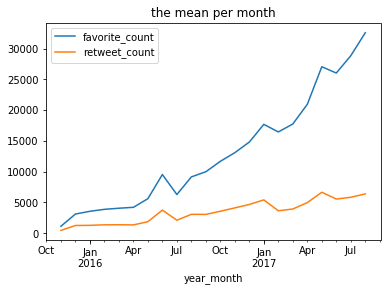

In [45]:
#make a new column containg only year & month
master['year_month'] =master['timestamp'].dt.to_period('M')
# plot the averge favorite_counts and retweet_counts for each month
master.groupby('year_month')['favorite_count'].mean() .plot(kind='line')
master.groupby('year_month')['retweet_count'].mean() .plot(kind='line')
plt.legend(['favorite_count','retweet_count'])
plt.title('the mean per month')
plt.show()

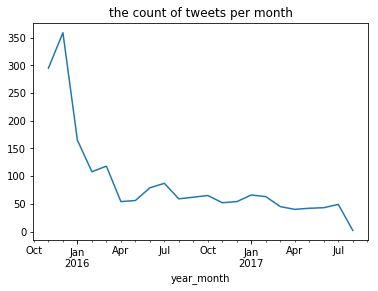

In [46]:
master.groupby('year_month')['timestamp'].count() .plot(kind='line')
plt.title('the count of tweets per month')
plt.show()

    RESULTS: favorite counts and retweet counts increased significantly overtime
    note: the count of tweets per month decreased over time (then almost stabilized)
          this means the raise in interaction with the tweets is not duo to posting more tweets
          but may be because of the raise in quality and popularity of the page

#### What makes a tweet interactive

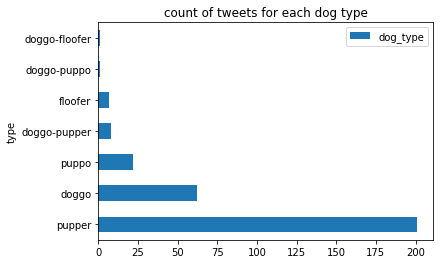

In [47]:
types_counts= pd.DataFrame(master['dog_type'].value_counts()).reset_index().rename(columns={'index':'type', 'name':'count'})
types_counts.head(15).plot(kind='barh', x='type')
plt.title('count of tweets for each dog type')
plt.show()

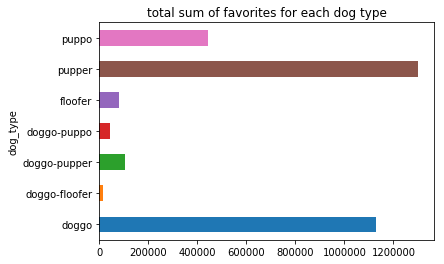

In [48]:
master.groupby('dog_type')['favorite_count'].sum() .plot(kind='barh')
plt.title('total sum of favorites for each dog type')
plt.show()

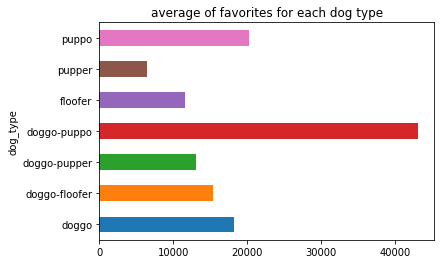

In [49]:
master.groupby('dog_type')['favorite_count'].mean() .plot(kind='barh')
plt.title('average of favorites for each dog type')
plt.show()

    RESULT: despite the fact that 'pupper' type has the most tweets with its name & most favorites in total
            but the 'doggo-puppo' has the highest favorites rate in average (means its posts are more interactive)

____________________________________

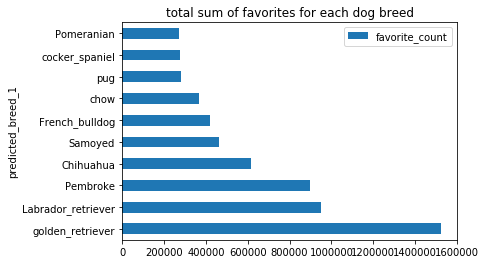

In [50]:
top_breed_sum= pd.DataFrame(master[master['is_a_dog?_1']==True].groupby('predicted_breed_1')
                        .sum()['favorite_count']).sort_values('favorite_count', ascending=False).head(10)
top_breed_sum.plot(kind='barh')
plt.title('total sum of favorites for each dog breed')
plt.show()

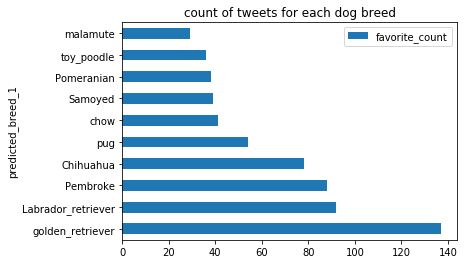

In [51]:
top_breed_count= pd.DataFrame(master[master['is_a_dog?_1']==True].groupby('predicted_breed_1')
                        .count()['favorite_count']).sort_values('favorite_count', ascending=False).head(10)
top_breed_count.plot(kind='barh')
plt.title('count of tweets for each dog breed')
plt.show()

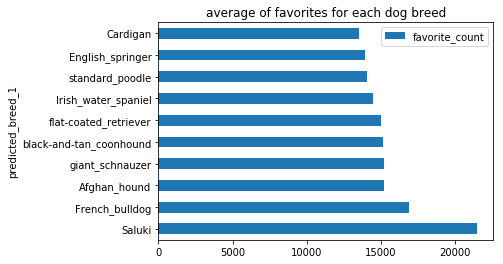

In [52]:
top_breed_mean= pd.DataFrame(master[master['is_a_dog?_1']==True].groupby('predicted_breed_1')
                        .mean()['favorite_count']).sort_values('favorite_count', ascending=False).head(10)
top_breed_mean.plot(kind='barh')
plt.title('average of favorites for each dog breed')
plt.show()

    RESULT:  the 'goloden_retriever' breed has the most tweets count & most favorites in total
    but the 'Saluki' breed has the highest favorites rate in average (means its posts are more interactive)

#### corelation between 'favorite_count' and 'retweet_count'

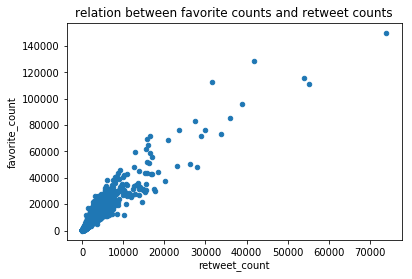

In [53]:
master.plot(x='retweet_count', y='favorite_count', kind='scatter')
plt.title('relation between favorite counts and retweet counts')
plt.show()

    RESULT:there is an obvious linear relation between the two

#### Statistics on the ratings

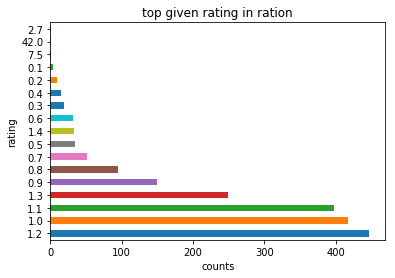

In [59]:
#make a new column include the rating (in ratio)
master['rating']= master['rating_numerator'] / master['rating_denominator']
sorted_ratings= pd.DataFrame(master['rating']).sort_values('rating')
sorted_ratings['rating'].value_counts().head(17).plot(kind='barh')
plt.title('top given rating in ration')
plt.xlabel("counts")
plt.ylabel("rating")
plt.show()

In [55]:
sorted_ratings.describe()

,rating
count,1963.000000
mean,1.169273
std,4.098959
min,0.000000
25%,1.000000
50%,1.100000
75%,1.200000
max,177.600000


    RESULT: the most common rating are 10/10 and higher

#### Most common dogs names

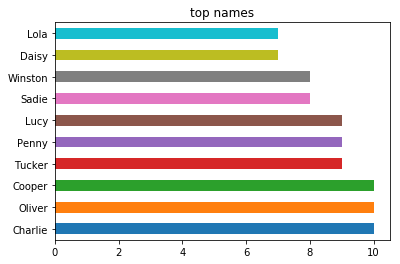

In [56]:
common_names= master['name'].value_counts().head(10)
common_names.plot(kind='barh')
plt.title('top names')
plt.show()

#### different sources of tweets

In [57]:
sources= master['source'].value_counts()
sources

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1925
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

    RESULT: the twitter for iphone is far more common the the web client in the page

#### Statistics on the confidences

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

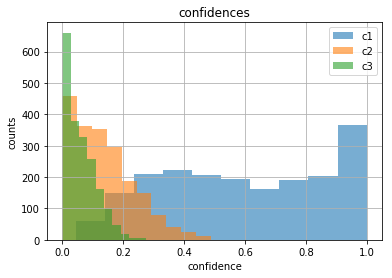

In [61]:
confidences= master[['confidence_1', 'confidence_2', 'confidence_3']]
confidences['confidence_1']= sorted(confidences['confidence_1'])
confidences['confidence_2']= sorted(confidences['confidence_2'])
confidences['confidence_3']= sorted(confidences['confidence_3'])

confidences['confidence_1'].hist(alpha=.6)
confidences['confidence_2'].hist(alpha=.6)
confidences['confidence_3'].hist(alpha=.6)
plt.legend(['c1','c2','c3'])
plt.title('confidences')
plt.xlabel("confidence")
plt.ylabel("counts")
plt.show()

    RESULT: predicted_breed_1 is way accurate than predicted_breed_2 & predicted_breed_3 
            (predicted_breed_1 was correct or almost correct many times)
            predicted_breed_3 had confidence almost 0 many times 
            ... so it's better to depend on predicted_breed_1 over the others (but don’t depend on it completely as it was wrong sometimes also)